# Setup

In [1]:
import os
from pathlib import Path

from PIL import Image
from ultralytics import YOLO
import cv2

In [2]:
root_dir = Path(os.getcwd()).parent
data_dir = root_dir / 'data'
runs_dir = root_dir / "runs"

In [3]:
used_data = 'rddc2020_use_pascal'

# Training

In [4]:
# Load a model
model = YOLO(
    "yolov8m.pt"
    )

# Use the model
results = model.train(
    data=data_dir/ used_data /"rddc2020_use_pascal_data.yaml",
    epochs=500,
    batch=32,
    patience=10
    )  # train the model

Ultralytics YOLOv8.0.200  Python-3.9.18 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=d:\ss_arasyidi_ds\4_pupr_rddc\yolov8_custom\data\rddc2020_use_pascal\rddc2020_use_pascal_data.yaml, epochs=500, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=Fals

# Inferencing

## Image

In [9]:
# Load a pretrained YOLOv8n model
best_model = YOLO(runs_dir / 'train9/weights/best.pt')

In [10]:
# Run inference on an image
results = best_model(root_dir / "notebooks" / "original.jpg")  # list of 1 Results object


image 1/1 d:\ss_arasyidi_ds\4_pupr_rddc\yolov8_custom\notebooks\original.jpg: 384x640 1 retak_memanjang, 61.0ms
Speed: 3.0ms preprocess, 61.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)


In [11]:
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image

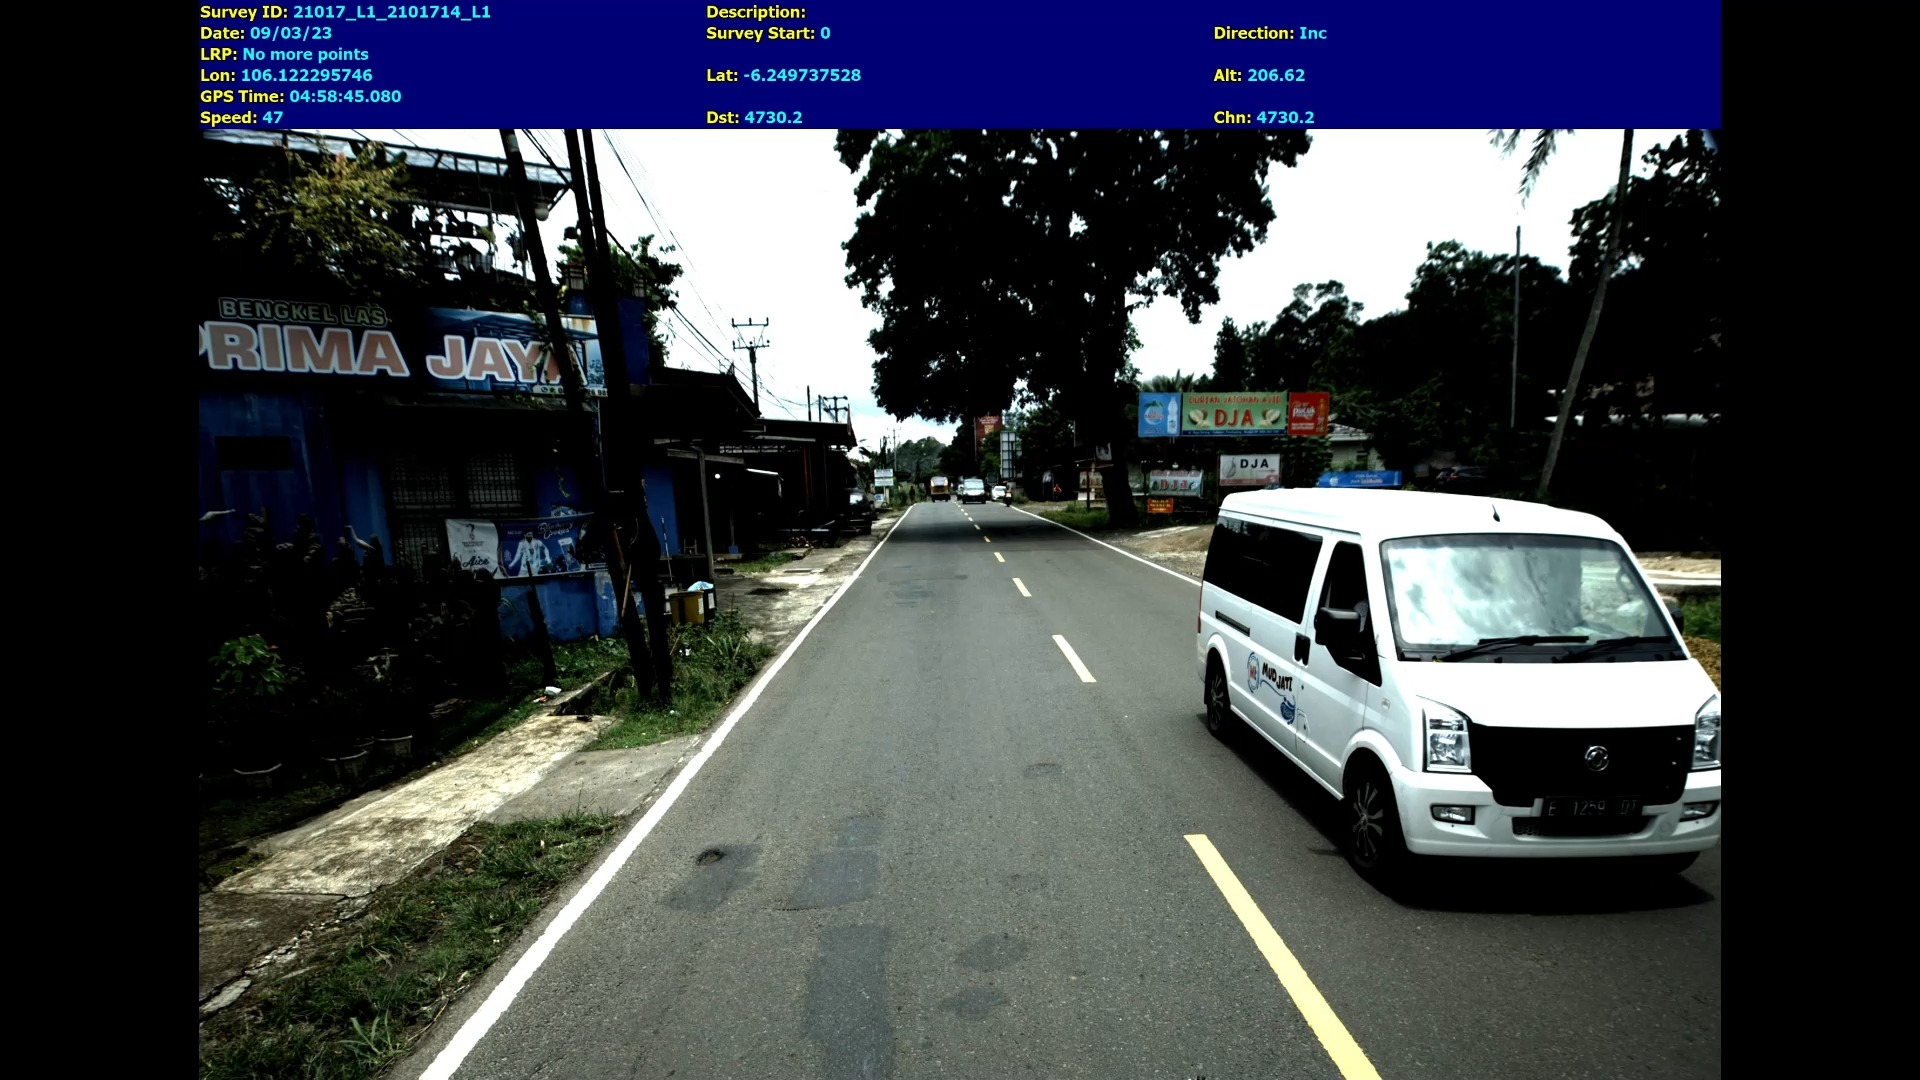

In [8]:
im

## Video

In [ ]:
video_path = r"D:\0_amri_local\14_pupr_roaddamagedetection\data\PUPR\Banten\21017 R1.mp4"
video_path_out = r"D:\0_amri_local\14_pupr_roaddamagedetection\yolov8_custom\notebooks\out.mp4"

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
H, W, _ = frame.shape
out = cv2.VideoWriter(video_path_out, cv2.VideoWriter_fourcc(*'MP4V'), int(cap.get(cv2.CAP_PROP_FPS)), (W, H))

In [ ]:
threshold = 0.5

while ret:

    results = best_model(frame)[0]

    for result in results.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = result

        if score > threshold:
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 4)
            cv2.putText(frame, results.names[int(class_id)].upper(), (int(x1), int(y1 - 10)),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.3, (0, 255, 0), 3, cv2.LINE_AA)

    out.write(frame)
    ret, frame = cap.read()

cap.release()
out.release()
cv2.destroyAllWindows()